In [ ]:
! pip install torch transformers datasets scikit-learn accelerate

In [1]:
import os
import glob
import random
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    Seq2SeqTrainer, 
    Seq2SeqTrainingArguments, 
    DataCollatorForSeq2Seq
)

import os

# 强制只使用 GPU 0 (3090)
# 或者你可以设置为 "2" 使用另一张 3090
# 或者设置为 "0,2" 同时使用两张 (但这需要多卡并行代码，暂时先用单卡最稳)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 再次确认
import torch
if torch.cuda.is_available():
    print(f"当前使用的显卡: {torch.cuda.get_device_name(0)}")
    print(f"显存总量: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("未检测到 GPU")

# ================= 配置参数 =================
# 论文选用的基座模型：CodeT5p 770M (Encoder-Decoder) 
MODEL_NAME = "Salesforce/codet5p-770m"

# 您的数据路径
DATA_DIR = "/home/wyq/GenKubeSec_Reproduce/raw_100_yaml_files"

# 论文限制：CodeT5p 770M 的最大 Token 为 512 
MAX_LENGTH = 512

# 论文设定：Masking 比例为 15% 
MASK_RATIO = 0.15

# 输出目录
OUTPUT_DIR = "/ssd_2t_1/wyq_workspace/genkubesect_structural_model"

# 训练参数 (根据您的显存调整，RTX 4090 可以尝试 batch_size=4 或 8)
BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 2e-5
SEED = 42
GRADIENT_ACCUMULATION_STEPS = 2

# 设置随机种子以复现结果
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print(f"配置完成。数据目录: {DATA_DIR}")

当前使用的显卡: NVIDIA GeForce RTX 3090
显存总量: 23.56 GB
配置完成。数据目录: /home/wyq/GenKubeSec_Reproduce/raw_100_yaml_files


In [2]:
def load_yaml_files(directory):
    """
    加载目录下所有的 .yaml 和 .yml 文件作为未标注数据集 [cite: 159, 214]。
    """
    files = glob.glob(os.path.join(directory, "**/*.yaml"), recursive=True)
    files += glob.glob(os.path.join(directory, "**/*.yml"), recursive=True)
    
    print(f"正在扫描目录: {directory}")
    print(f"找到 {len(files)} 个 YAML 文件")
    
    contents = []
    for f in files:
        try:
            with open(f, 'r', encoding='utf-8') as file:
                content = file.read()
                if content.strip(): # 过滤空文件
                    contents.append(content)
        except Exception as e:
            # print(f"Error reading {f}: {e}") # 调试时可打开
            pass
            
    return contents

# 执行加载
raw_texts = load_yaml_files(DATA_DIR)
print(f"成功加载 {len(raw_texts)} 个有效文件内容。")

正在扫描目录: /home/wyq/GenKubeSec_Reproduce/raw_100_yaml_files
找到 100 个 YAML 文件
成功加载 100 个有效文件内容。


In [ ]:
! pip install --upgrade ipywidgets

In [4]:
os.environ["http_proxy"] = "http://127.0.0.1:36217"
os.environ["https_proxy"] = "http://127.0.0.1:36217"

# 可选：在加载大模型前做一个快速的网络连通性检查
import time
try:
    import requests
except Exception:
    requests = None

hf_check_url = "https://huggingface.co"
if requests is not None:
    try:
        print(f"检查网络连通性：{hf_check_url} (timeout=5s) ...")
        r = requests.head(hf_check_url, timeout=5)
        print(f"网络可达，状态码：{r.status_code}")
    except Exception as e:
        print("无法访问 huggingface.co（可能网络或代理问题）。尝试继续，但加载可能会阻塞或失败：", e)
else:
    print("未检测到 requests 库，跳过网络连通性快速检查。")

# 初始化 Tokenizer（记录加载时间以便判断是否卡住）
print(f"开始加载 tokenizer: {MODEL_NAME}")
t0 = time.time()
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
t1 = time.time()
print(f"tokenizer 加载完成，耗时: {t1 - t0:.1f}s")

# 确保有 Mask Token (CodeT5 默认可能有特定 sentinel tokens，这里为了简化使用通用 mask 策略)
if not tokenizer.mask_token:
    tokenizer.mask_token = "<mask>"

def prepare_structural_tasks(examples):
    """
    数据预处理函数：将原始文本转换为模型训练所需的 Input-Target 对。
    包含数据过滤逻辑：丢弃超过 512 Tokens 的样本 [cite: 278, 400]。
    在此函数内加入进度显示（使用 tqdm）并统计被丢弃的样本数。
    """
    inputs = []
    targets = []
    skipped = 0
    total = 0
    try:
        from tqdm import tqdm
    except Exception:
        tqdm = None

    iterator = examples['text'] if tqdm is None else tqdm(examples['text'], desc="preprocess")
    for content in iterator:
        total += 1
        # 1. 初始 Tokenize (不截断，用于检查长度)
        try:
            tokens = tokenizer(content, truncation=False, add_special_tokens=False)['input_ids']
        except Exception as e:
            # 如果 tokenizer 因异常中断，打印信息并跳过该样本
            print("Tokenizer 处理某条样本时出现异常，已跳过：", e)
            skipped += 1
            continue

        # 2. 过滤逻辑：丢弃超过 512 token 的长文件 [cite: 279]
        if len(tokens) > MAX_LENGTH - 5:
            skipped += 1
            continue

        # 3. 随机选择任务类型 (50% 概率)
        task_type = random.choice(['NSP', 'MASKING'])

        if task_type == 'NSP':
            # --- Next Sentence Prediction (NSP)  ---
            # 预测后半部分基于前半部分
            split_point = len(tokens) // 2
            input_ids = tokens[:split_point]
            label_ids = tokens[split_point:]
            
            inputs.append(tokenizer.decode(input_ids))
            targets.append(tokenizer.decode(label_ids))
        else:
            # --- Masking  ---
            # 随机遮蔽 15% 的 Token
            num_mask = max(1, int(len(tokens) * MASK_RATIO))
            mask_indices = set(random.sample(range(len(tokens)), num_mask))
            
            masked_input_ids = []
            for idx, token_id in enumerate(tokens):
                if idx in mask_indices:
                    masked_input_ids.append(tokenizer.mask_token_id)
                else:
                    masked_input_ids.append(token_id)
            
            # 目标是恢复原始文本 (Denoising)
            inputs.append(tokenizer.decode(masked_input_ids))
            targets.append(content)

    # 4. 最终编码
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=MAX_LENGTH, padding="max_length", truncation=True)

    # 将 Pad Token 的 label 设为 -100，计算 loss 时忽略
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    print(f"prepare_structural_tasks: 处理总数={total}, 跳过={skipped}, 有效={len(inputs)}")
    return model_inputs

检查网络连通性：https://huggingface.co (timeout=5s) ...
网络可达，状态码：200
开始加载 tokenizer: Salesforce/codet5p-770m
tokenizer 加载完成，耗时: 1.6s


In [5]:
# 创建原始数据集
raw_dataset = Dataset.from_dict({"text": raw_texts})

print("开始应用预处理 (Masking & NSP)... 这可能需要几分钟。")
processed_dataset = raw_dataset.map(
    prepare_structural_tasks,
    batched=True,
    batch_size=10,
    remove_columns=["text"],
    desc="Processing dataset"
)

print(f"预处理完成。")
print(f"原始文件数: {len(raw_dataset)}")
print(f"符合长度要求(<=512 tokens)的样本数: {len(processed_dataset)}")

# 划分训练集和验证集 (90% 训练, 10% 验证) [cite: 216]
# 虽然论文是 80/10/10，但在 Structural 阶段我们可以多用一点数据做训练
split_dataset = processed_dataset.train_test_split(test_size=0.1, seed=SEED)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(eval_dataset)}")

开始应用预处理 (Masking & NSP)... 这可能需要几分钟。


Processing dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors
preprocess: 100%|██████████| 10/10 [00:00<00:00, 571.99it/s]


prepare_structural_tasks: 处理总数=10, 跳过=2, 有效=8


preprocess: 100%|██████████| 10/10 [00:00<00:00, 106.54it/s]


prepare_structural_tasks: 处理总数=10, 跳过=2, 有效=8


preprocess: 100%|██████████| 10/10 [00:00<00:00, 1050.07it/s]


prepare_structural_tasks: 处理总数=10, 跳过=2, 有效=8


preprocess: 100%|██████████| 10/10 [00:00<00:00, 980.64it/s]


prepare_structural_tasks: 处理总数=10, 跳过=1, 有效=9


preprocess: 100%|██████████| 10/10 [00:00<00:00, 1122.10it/s]


prepare_structural_tasks: 处理总数=10, 跳过=1, 有效=9


preprocess: 100%|██████████| 10/10 [00:00<00:00, 993.09it/s]


prepare_structural_tasks: 处理总数=10, 跳过=1, 有效=9


preprocess: 100%|██████████| 10/10 [00:00<00:00, 1329.58it/s]


prepare_structural_tasks: 处理总数=10, 跳过=0, 有效=10


preprocess: 100%|██████████| 10/10 [00:00<00:00, 1476.92it/s]


prepare_structural_tasks: 处理总数=10, 跳过=1, 有效=9


preprocess: 100%|██████████| 10/10 [00:00<00:00, 1307.45it/s]


prepare_structural_tasks: 处理总数=10, 跳过=1, 有效=9


preprocess: 100%|██████████| 10/10 [00:00<00:00, 866.73it/s]


prepare_structural_tasks: 处理总数=10, 跳过=3, 有效=7
预处理完成。
原始文件数: 100
符合长度要求(<=512 tokens)的样本数: 86
训练集大小: 77
验证集大小: 9


In [6]:
import random

def show_random_sample(dataset, tokenizer, num_samples=3):
    """
    随机抽取样本并解码显示，用于检查预处理逻辑。
    """
    # 确保样本数不超过数据集大小
    num_samples = min(num_samples, len(dataset))
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        
        print(f"\n{'='*20} 样本 {i+1} (Index: {idx}) {'='*20}")
        
        # 1. 解码 Input
        # skip_special_tokens=False 是为了能看到 padding 和 mask token
        input_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)
        
        # 2. 解码 Label
        # 注意：我们在预处理时将 padding 的 label 设为了 -100，
        # -100 在 tokenizer 中无法解码，必须先替换回 pad_token_id
        label_ids = [
            (token if token != -100 else tokenizer.pad_token_id) 
            for token in sample['labels']
        ]
        label_text = tokenizer.decode(label_ids, skip_special_tokens=False)
        
        # 3. 打印对比
        print(f"🔴 [Input (模型输入)]:\n{input_text[:500]}...") # 只打印前500字符避免刷屏
        print(f"\n🟢 [Label (预测目标)]:\n{label_text[:500]}...")
        
        # 4. 简单分析任务类型
        if "<mask>" in input_text or tokenizer.mask_token in input_text:
            print("\n🔍 任务类型推断: Masking (填空任务)")
        else:
            print("\n🔍 任务类型推断: NSP (下一句预测 / 序列补全)")

# 从训练集中查看
print("查看训练集样本:")
show_random_sample(train_dataset, tokenizer)

查看训练集样本:

==================== 样本 1 (Index: 38) ====================
🔴 [Input (模型输入)]:
<s>apiVersion: v1
data: {}
kind: Secret
metadata:
  labels:
    app.kubernetes.io/component: query-layer
    app.kubernetes.io/instance: thanos-querier
    app.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><...

🟢 [Label (预测目标)]:
<s>kubernetes.io/name: thanos-query
    app.kubernetes.io/version: 0.19.0
  name: thanos-querier-oauth-cookie
  namespace: openshift-monitoring
type: Opaque
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [7]:
os.environ['http_proxy'] = 'http://127.0.0.1:36217'
os.environ['https_proxy'] = 'http://127.0.0.1:36217'
print(f"加载模型: {MODEL_NAME}")
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# 移动到 GPU (如果可用)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"模型已加载至: {device}")

加载模型: Salesforce/codet5p-770m
模型已加载至: cuda


In [8]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # 批次大小设置
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    gradient_checkpointing=True,

    # 优化参数
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    
    # 保存与评估策略
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,  # 只保留最近2个checkpoint，节省空间
    
    # 精度优化
    fp16=torch.cuda.is_available(), # 如果有 GPU 推荐开启混合精度
    
    # 日志
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=50,
    
    # 其他
    predict_with_generate=True,
    report_to="none" # 不上传到 wandb 等平台，仅本地
)

# 数据整理器
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 初始化 Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipykernel_614590/988558215.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [9]:
print("开始 Structural Adaptation 训练...")
# 这可能需要一些时间，取决于您的 GPU 性能和数据量
trainer.train()

开始 Structural Adaptation 训练...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,No log,0.370250
2,No log,0.316013
3,No log,0.301212


TrainOutput(global_step=30, training_loss=0.8179793039957682, metrics={'train_runtime': 65.6614, 'train_samples_per_second': 3.518, 'train_steps_per_second': 0.457, 'total_flos': 500125925376000.0, 'train_loss': 0.8179793039957682, 'epoch': 3.0})

In [11]:
! pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 22.5 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


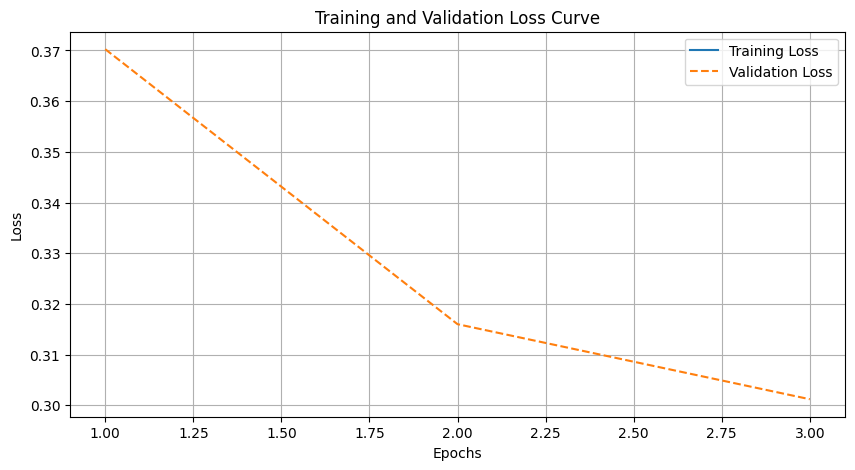

In [12]:
import matplotlib.pyplot as plt

def plot_loss(trainer):
    log_history = trainer.state.log_history
    
    # 提取训练集 loss
    train_steps = []
    train_loss = []
    
    # 提取验证集 loss
    eval_steps = []
    eval_loss = []
    
    for log in log_history:
        if "loss" in log and "epoch" in log:
            train_steps.append(log["epoch"])
            train_loss.append(log["loss"])
        if "eval_loss" in log and "epoch" in log:
            eval_steps.append(log["epoch"])
            eval_loss.append(log["eval_loss"])
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_steps, train_loss, label="Training Loss")
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label="Validation Loss", linestyle='--')
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(trainer)

In [ ]:
print(f"保存最终模型到: {OUTPUT_DIR}")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("Phase 2 - Step 1 (Structural Adaptation) 完成！")
print("您现在可以使用此模型进行下一阶段：使用标注数据进行 LoRA 微调 (Misconfig Detection)。")